# Rock Paper Scissors

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Loading the dataset

In [2]:
# See available datasets
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'i_natura

In [13]:
(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name='rock_paper_scissors',
    data_dir='.tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [14]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw train dataset size: 2520 

Raw test dataset: <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw test dataset size: 372 



In [15]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [52]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES);
print('Number of TEST examples:', NUM_TEST_EXAMPLES);

Number of TRAIN examples: 2520
Number of TEST examples: 372


In [96]:
INPUT_IMG_SHAPE = dataset_info.features['image'].shape
INPUT_IMG_SIZE = dataset_info.features['image'].shape[0]

print('Input image shape:', INPUT_IMG_SHAPE)
print('Input image size:', INPUT_IMG_SIZE)

Input image shape: (300, 300, 3)
Input image size: 300


In [36]:
ROCK_PAPER_SCISSORS_LABELS = {
    0: 'rock',
    1: 'paper',
    2: 'scissors'
}

## Exploring the dataset

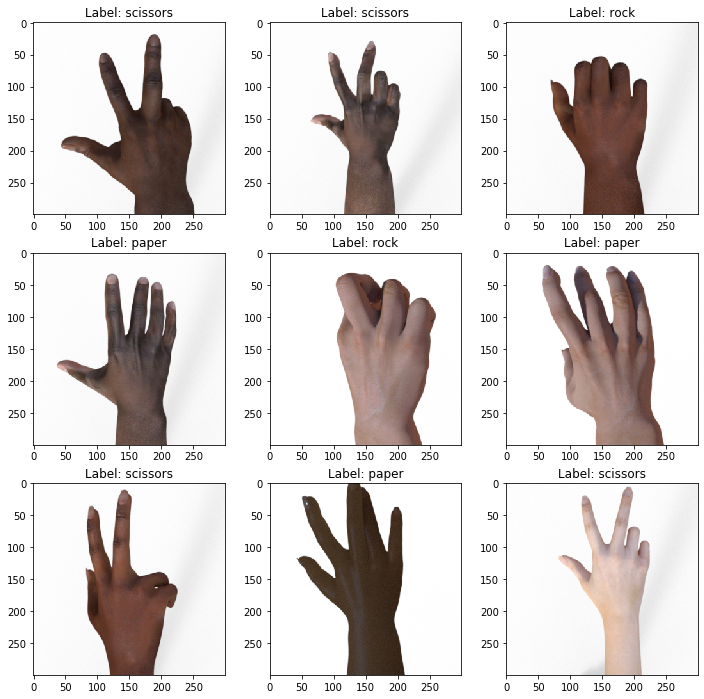

In [40]:
# Explore first 9 examples from the dataset.
plt.figure(figsize=(12, 12))
plot_index = 0
for features in dataset_train_raw.take(9):
    (image, label) = features
    plot_index += 1
    plt.subplot(3, 3, plot_index)
    # plt.axis('Off')
    label = ROCK_PAPER_SCISSORS_LABELS[label.numpy()]
    plt.title('Label: %s' % label)
    plt.imshow(image.numpy())

In [97]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train_raw.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


## Pre-processing the dataset

In [102]:
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [103]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[0.99607843 0.99607843 0.99607843]
  [0.99215686 0.99215686 0.99215686]
  [0.99607843 0.99607843 0.99607843]
  ...
  [0.9843137  0.9843137  0.9843137 ]
  [0.98039216 0.98039216 0.98039216]
  [0.98039216 0.98039216 0.98039216]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99215686 0.99215686 0.99215686]
  ...
  [0.98039216 0.98039216 0.98039216]
  [0.9843137  0.9843137  0.9843137 ]
  [0.9764706  0.9764706  0.9764706 ]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  ...
  [0.9843137  0.9843137  0.9843137 ]
  [0.98039216 0.98039216 0.98039216]
  [0.9882353  0.9882353  0.9882353 ]]

 ...

 [[0.9882353  0.9882353  0.9882353 ]
  [0.9843137  0.9843137  0.9843137 ]
  [0.9882353  0.9882353  0.9882353 ]
  ...
  [0.96862745 0.96862745 0.96862745]
  [0.9764706  0.9764706  0.9764706 ]
  [0.972549   0.972549   0.972549  ]]

 [[0.99215686 0.99215686 0.9921568

## Data augmentation

In [ ]:
dataset, dataset_info = tfds.load(
    name='rock_paper_scissors',
    split=tfds.Split.TRAIN,
    data_dir='.tmp',
    with_info=True
)

In [ ]:
len(list(dataset))

In [ ]:
list(dataset)[:2]

In [ ]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

train_generator = training_datagen.flow(
    dataset['train'],
#     dataset['train'],
#     target_size=(150,150),
#     class_mode='categorical'
)

## Creating a model

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D())

# Combined version

http://www.laurencemoroney.com/rock-paper-scissors-dataset/

https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%208%20-%20Lesson%202%20-%20Notebook%20(RockPaperScissors).ipynb#scrollTo=ZABJp7T3VLCU

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6])
dataset = dataset.shuffle(5).batch(2)
list(dataset)

In [ ]:
history_2 = model.fit_generator(
    dataset['train'],
    epochs=5,
    validation_data = dataset['test'],
    verbose = 1
)

# Laurence version

In [ ]:
!curl https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip -o .tmp/rps.zip
!curl https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip -o .tmp/rps-test-set.zip

In [ ]:
import os
import zipfile

local_zip = '.tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.tmp/')
zip_ref.close()

local_zip = '.tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.tmp/')
zip_ref.close()

In [ ]:
rock_dir = os.path.join('.tmp/rps/rock')
paper_dir = os.path.join('.tmp/rps/paper')
scissors_dir = os.path.join('.tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)), '\n')
print('total training paper images:', len(os.listdir(paper_dir)), '\n')
print('total training scissors images:', len(os.listdir(scissors_dir)), '\n')

rock_files = os.listdir(rock_dir)
print(rock_files[:10], '\n')

paper_files = os.listdir(paper_dir)
print(paper_files[:10], '\n')

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

In [ ]:
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock + next_paper + next_scissors):
    # print(img_path)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

In [ ]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = '.tmp/rps/'
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

VALIDATION_DIR = ".tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
history = model.fit_generator(
    train_generator,
    epochs=5,
    validation_data = validation_generator,
    verbose = 1
)

In [ ]:
model.save('rps.h5')

In [ ]:
history.params

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.show()